In [218]:
import pandas
import csv
import numpy as np
from numpy import linalg
from matplotlib import pyplot as plt
import math
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils

In [3]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [4]:
def generateConcatenateFeatures(filePath,feature_dict):
    df = pandas.read_csv(filePath)
    df = df.values
    features_append = []
    for i in range(len(df)):
#         if(i>=791):
#             break
        feature = []
        feature += feature_dict[df[i][0]]
        feature += feature_dict[df[i][1]]
        feature.append(df[i][2])
        features_append.append(feature)
    print(len(features_append))
    return np.asarray(features_append)

In [142]:
def generateSubtractFeatures(filePath,feature_dict):
    df = pandas.read_csv(filePath)
    df = df.values
    features_append = []
    for i in range(len(df)):
#         if(i>=791):
#             break
        feature = []
        feature += (np.absolute(np.asarray(feature_dict[df[i][0]]) - np.asarray(feature_dict[df[i][1]]))).tolist()
        feature.append(df[i][2])
        features_append.append(feature)
    print(len(features_append))
    return np.asarray(features_append)

In [389]:
def GenerateTargetAndData(targetData,featureData,percentage,index):
    size = int(math.ceil(len(targetData)*(percentage*0.01)))
    end = index + size
    if(index==0):
        target = targetData[:end]
        dataMatrix = featureData[:,0:end]
    else:
        target = targetData[index+1:end]
        dataMatrix = featureData[:,index+1:end]

    return np.array(target),dataMatrix

In [7]:
def GenerateBigSigma(Data,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        '''calculates variances of each feature vector'''
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    '''Here we do not care about the variances between different feature vector hence, we fill only the diagonal
    elements for the big sigma matrix'''
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    '''To magnify the values as they are quite small we do a dot product with 200.'''
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    #print ("BigSigma Generated..")
    return BigSigma

In [8]:
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L
# Gaussian basis function
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x


In [9]:
# generates phi matrix based on the type of basis function
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    #takes inverse of big sigma matrix
    BigSigInv = np.linalg.pinv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)    
    #print ("PHI Generated..")
    return PHI

In [267]:
# generates predicted target values using weights and design matrix
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

# generates predicted target values using weights and design matrix
def GetValTestSigmoid(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    Sig_T  = sigmoid_v(Y)
    ##print ("Test Out Generated..")
    return Sig_T

# calculates Erms from the predicted output and the actual output values
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

In [206]:
def GetCrossEntropy(VAL_TEST_OUT,ValDataAct,eps=math.pow(10,-15)):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        y = ValDataAct[i]
        a = min(max(VAL_TEST_OUT[i],eps),1-eps)
       # a = VAL_TEST_OUT[i]
        logLoss = - (y * math.log(a) + (1-y)*math.log(1-a))
        sum = sum + logLoss
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    return (str(accuracy) + ',' +  str((sum/len(VAL_TEST_OUT))))

In [21]:
def getBounds(index,batchsize,maxi):
    if((index+1)*batchsize>maxi):
        return index*batchsize,maxi
    else:
        return index*batchsize,(index+1)*batchsize

In [200]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# Linear Regression - Stochastic Gradient Descent

In [23]:
def LinearRegression(Target,Features,batchsize,epochs):
    # Dividing dataset into training,testing and validation
    TrainingTarget,TrainingData = GenerateTargetAndData(Target,Features,TrainingPercent,0)
    print('Training target size:',TrainingTarget.shape)
    print('Training feature size:',TrainingData.shape)
    ValDataAct,ValData = GenerateTargetAndData(Target,Features,ValidationPercent,(len(TrainingTarget)))
    print('Validation target size:',ValDataAct.shape)
    print('Validation feature size:',ValData.shape)
    TestDataAct,TestData = GenerateTargetAndData(Target,Features,TestPercent,(len(TrainingTarget)+len(ValDataAct)))
    print('Testing target size:',TestDataAct.shape)
    print('Testing feature size:',TestData.shape)

    print('Number of basis functions used:',M)
    kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_
    BigSigma     = GenerateBigSigma(Features, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(Features, Mu, BigSigma, TrainingPercent) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
    
    print('Mu Shape',Mu.shape)
    print('BigSigma shape',BigSigma.shape)
    print('training phi shape',TRAINING_PHI.shape)
    print('validation phi shape',VAL_PHI.shape)
    print('testing phi shape',TEST_PHI.shape)
    
    
    #initializing weights
    W_Now = np.ones(M)
    La  = 2
    lr = 0.01
   
   
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    L_Acc_Val   = []
    L_Acc_TR    = []
    L_Acc_Test  = []
    W_Mat        = []
    for i in tqdm(range(epochs)):
        for i in range(int(len(TrainingTarget)/batchsize)):
            # adapting weights according to the learning rate
            #print ('---------Iteration: ' + str(i) + '--------------')
            lower,upper   = getBounds(i,batchsize,len(TrainingTarget))
            Predicted_T   = np.dot(np.transpose(W_Now),np.transpose(TRAINING_PHI[lower:upper]))
            Delta         = -np.subtract(TrainingTarget[lower:upper],Predicted_T)
            Delta_E_D     = np.transpose(TRAINING_PHI[lower:upper]) * Delta
            La_Delta_E_W  = np.dot(La,W_Now)
            Delta_E       = np.add(np.transpose(Delta_E_D),La_Delta_E_W)    
            Delta_W       = -np.dot(lr,Delta_E_D)
            Delta_E_W     = np.mean(Delta_W,axis=1)
            W_T_Next      = W_Now + Delta_E_W
            W_Now         = W_T_Next

            # calculating error and accuracy during the learning process
            #-----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
            Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
            L_Erms_TR.append(float(Erms_TR.split(',')[1]))
            L_Acc_TR.append(float(Erms_TR.split(',')[0]))

            #-----------------ValidationData Accuracy---------------------#
            VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
            Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
            L_Erms_Val.append(float(Erms_Val.split(',')[1]))
            L_Acc_Val.append(float(Erms_TR.split(',')[0]))

            #-----------------TestingData Accuracy---------------------#
            TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
            Erms_Test = GetErms(TEST_OUT,TestDataAct)
            L_Erms_Test.append(float(Erms_Test.split(',')[1]))
            L_Acc_Test.append(float(Erms_Test.split(',')[0]))


    return W_Now,L_Erms_Val,L_Erms_TR,L_Erms_Test,L_Acc_Val,L_Acc_TR,L_Acc_Test

In [16]:
image_features = pandas.read_csv('HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv')

feature_dict_HOD = image_features.set_index('img_id').T[1:].to_dict('list')
print(len(feature_dict_HOD))

1026


In [17]:
filePathSamePairs = 'HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv'
filePathDiffPairs = 'HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv'

In [18]:
featureSamePairsConcatenate = generateConcatenateFeatures(filePathSamePairs,feature_dict_HOD)
featureDiffPairsConcatenate = generateConcatenateFeatures(filePathDiffPairs,feature_dict_HOD)
featureDiffPairsConcatenateRandom = featureDiffPairsConcatenate[np.random.choice(featureDiffPairsConcatenate.shape[0], len(featureSamePairsConcatenate), replace=False), :]
print(len(featureDiffPairsConcatenateRandom))
featuresHODConcat = np.concatenate((featureSamePairsConcatenate,featureDiffPairsConcatenateRandom))

791
293032
791


In [19]:
np.random.shuffle(featuresHODConcat)
XconcatHOD = np.transpose(featuresHODConcat[:,:18])
TconcatHOD = featuresHODConcat[:,18]
print(XconcatHOD.shape)
print(TconcatHOD.shape)

(18, 1582)
(1582,)


In [306]:
batchsize = 5
epochs = 10
W,L_Erms_Val,L_Erms_TR,L_Erms_Test,L_Acc_Val,L_Acc_TR,L_Acc_Test = LinearRegression(TconcatHOD,XconcatHOD,batchsize,epochs)

Training target size: (1266,)
Training feature size: (18, 1266)
Validation target size: (158,)
Validation feature size: (18, 158)
Testing target size: (157,)
Testing feature size: (18, 157)
Number of basis functions used: 10
Mu Shape (10, 18)
BigSigma shape (18, 18)
training phi shape (1266, 10)
validation phi shape (158, 10)
testing phi shape (157, 10)


In [307]:
print ('Linear Regression | Concatenation | Human Observed Dataset')
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_Acc_Test),5)))

Linear Regression | Concatenation | Human Observed Dataset
E_rms Training   = 0.49951
E_rms Validation = 0.49776
E_rms Testing    = 0.49849
Accuracy Training   = 55.21327
Accuracy Validation = 55.21327
Accuracy Testing    = 59.23567


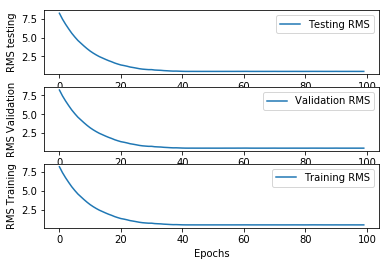

In [308]:
i = [j for j in range(100)]
plt.figure(1)               
ax = plt.subplot(311)
ax.plot(i, L_Erms_Test[:100],label ='Testing RMS')
plt.ylabel('RMS testing')
plt.xlabel('Epochs')
ax.legend()
ax = plt.subplot(312)             
ax.plot(i, L_Erms_Val[:100],label ='Validation RMS')
plt.ylabel('RMS Validation')
plt.xlabel('Epochs')
ax.legend()
ax = plt.subplot(313)             
ax.plot(i, L_Erms_TR[:100],label ='Training RMS')
plt.ylabel('RMS Training')
plt.xlabel('Epochs')
ax.legend()

plt.show()

In [143]:
featureSamePairsSubtract = generateSubtractFeatures(filePathSamePairs,feature_dict_HOD)
featureDiffPairsSubtract = generateSubtractFeatures(filePathDiffPairs,feature_dict_HOD)
# picking equal distribution of features
featureDiffPairsSubtractRandom = featureDiffPairsSubtract[np.random.choice(featureDiffPairsSubtract.shape[0], len(featureSamePairsSubtract), replace=False), :]
featuresHODSubtract = np.concatenate((featureSamePairsSubtract,featureDiffPairsSubtractRandom))
print(len(featuresHODSubtract))

791
293032
1582


In [144]:
np.random.shuffle(featuresHODSubtract)
XsubtractHOD = np.transpose(featuresHODSubtract[:,:9])
TsubtractHOD = featuresHODSubtract[:,9]
print(XsubtractHOD.shape)
print(TsubtractHOD.shape)

(9, 1582)
(1582,)


In [312]:
batchsize = 5
epochs = 10
W_S,L_S_Erms_Val,L_S_Erms_TR,L_S_Erms_Test,L_S_Acc_Val,L_S_Acc_TR,L_S_Acc_Test = LinearRegression(TsubtractHOD,XsubtractHOD,batchsize,epochs)

Training target size: (1266,)
Training feature size: (9, 1266)
Validation target size: (158,)
Validation feature size: (9, 158)
Testing target size: (157,)
Testing feature size: (9, 157)
Number of basis functions used: 10
Mu Shape (10, 9)
BigSigma shape (9, 9)
training phi shape (1266, 10)
validation phi shape (158, 10)
testing phi shape (157, 10)


In [315]:
print ('Linear Regression | Subtraction | Human Observed Dataset')
print ("E_rms Training   = " + str(np.around(min(L_S_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_S_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_S_Erms_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_S_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_S_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_S_Acc_Test),5)))

Linear Regression | Subtraction | Human Observed Dataset
E_rms Training   = 0.49964
E_rms Validation = 0.49607
E_rms Testing    = 0.49891
Accuracy Training   = 53.79147
Accuracy Validation = 53.79147
Accuracy Testing    = 61.78344


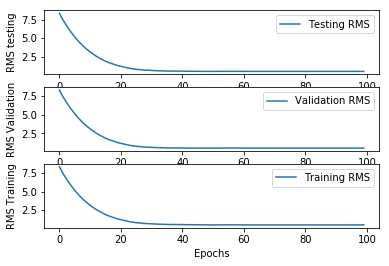

In [314]:
i = [j for j in range(100)]
plt.figure(1)               
ax = plt.subplot(311)
ax.plot(i, L_S_Erms_Test[:100],label ='Testing RMS')
plt.ylabel('RMS testing')
plt.xlabel('Epochs')
ax.legend()
ax = plt.subplot(312)             
ax.plot(i, L_S_Erms_Val[:100],label ='Validation RMS')
plt.ylabel('RMS Validation')
plt.xlabel('Epochs')
ax.legend()
ax = plt.subplot(313)             
ax.plot(i, L_S_Erms_TR[:100],label ='Training RMS')
plt.ylabel('RMS Training')
plt.xlabel('Epochs')
ax.legend()

plt.show()

In [15]:
image_features = pandas.read_csv('GSC-Dataset/GSC-Features-Data/GSC-Features.csv')

feature_dict_GSC = image_features.set_index('img_id').T.to_dict('list')
print(len(feature_dict_GSC))
# for f,k in feature_dict.items():
#     print(f,k)

14072


In [40]:
GSCfilePathSamePairs = 'GSC-Dataset/GSC-Features-Data/same_pairs.csv'
GSCfilePathDiffPairs = 'GSC-Dataset/GSC-Features-Data/diffn_pairs.csv'

In [41]:
GSCfeatureSamePairsConcatenate = generateConcatenateFeatures(GSCfilePathSamePairs,feature_dict_GSC)
GSCfeatureDiffPairsConcatenate = generateConcatenateFeatures(GSCfilePathDiffPairs,feature_dict_GSC)
GSCfeatureSamePairsConcatenateRandom = GSCfeatureSamePairsConcatenate[np.random.choice(GSCfeatureSamePairsConcatenate.shape[0], 25000, replace=False), :]
GSCfeatureDiffPairsConcatenateRandom = GSCfeatureDiffPairsConcatenate[np.random.choice(GSCfeatureDiffPairsConcatenate.shape[0], 25000, replace=False), :]
featuresGSCConcat = np.concatenate((GSCfeatureSamePairsConcatenateRandom,GSCfeatureDiffPairsConcatenateRandom))
print(len(featuresGSCConcat))

71531
762557
50000


In [42]:
np.random.shuffle(featuresGSCConcat)
print(featuresGSCConcat.shape)
XconcatGSC = np.transpose(featuresGSCConcat[:,:1024])
TconcatGSC = featuresGSCConcat[:,1024]
print(XconcatGSC.shape)
print(TconcatGSC.shape)

(50000, 1025)
(1024, 50000)
(50000,)


In [360]:
batchsize = 500
epochs = 10
W_C_G,L_C_G_Erms_Val,L_C_G_Erms_TR,L_C_G_Erms_Test,L_C_G_Acc_Val,L_C_G_Acc_TR,L_C_G_Acc_Test = LinearRegression(TconcatGSC,XconcatGSC,batchsize,epochs)

Training target size: (40000,)
Training feature size: (1024, 40000)
Validation target size: (4999,)
Validation feature size: (1024, 4999)
Testing target size: (4999,)
Testing feature size: (1024, 4999)
Number of basis functions used: 10
Mu Shape (10, 1024)
BigSigma shape (1024, 1024)
training phi shape (40000, 10)
validation phi shape (4999, 10)
testing phi shape (4999, 10)


In [361]:
print ('Linear Regression | Concatenation | GSC Dataset')
print ("E_rms Training   = " + str(np.around(min(L_C_G_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_C_G_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_C_G_Erms_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_C_G_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_C_G_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_C_G_Acc_Test),5)))

Linear Regression | Concatenation | GSC Dataset
E_rms Training   = 0.59679
E_rms Validation = 0.5997
E_rms Testing    = 0.60067
Accuracy Training   = 51.3775
Accuracy Validation = 51.3775
Accuracy Testing    = 51.15023


In [ ]:
i = [j for j in range(800)]
plt.figure(1)               
ax = plt.subplot(311)
ax.plot(i, L_C_G_Erms_Test,label ='Testing RMS')
plt.ylabel('RMS testing')
plt.xlabel('Epochs')
ax.legend()
ax = plt.subplot(312)             
ax.plot(i, L_C_G_Erms_Val,label ='Validation RMS')
plt.ylabel('RMS Validation')
plt.xlabel('Epochs')
ax.legend()
ax = plt.subplot(313)             
ax.plot(i, L_C_G_Erms_TR,label ='Training RMS')
plt.ylabel('RMS Training')
plt.xlabel('Epochs')
ax.legend()

plt.show()

In [166]:
GSCfeatureSamePairsSubtract = generateSubtractFeatures(GSCfilePathSamePairs,feature_dict_GSC)
GSCfeatureDiffPairsSubtract = generateSubtractFeatures(GSCfilePathDiffPairs,feature_dict_GSC)
GSCfeatureSamePairsSubtractRandom = GSCfeatureSamePairsSubtract[np.random.choice(GSCfeatureSamePairsSubtract.shape[0], 25000, replace=False), :]
GSCfeatureDiffPairsSubtractRandom = GSCfeatureDiffPairsSubtract[np.random.choice(GSCfeatureDiffPairsSubtract.shape[0], 25000, replace=False), :]
featuresGSCSubtract = np.concatenate((GSCfeatureSamePairsSubtractRandom,GSCfeatureDiffPairsSubtractRandom))
print(len(featuresGSCSubtract))

71531
762557
50000


In [167]:
np.random.shuffle(featuresGSCSubtract)
print(featuresGSCSubtract.shape)
XsubtractGSC = np.transpose(featuresGSCSubtract[:,:512])
TsubtractGSC = featuresGSCSubtract[:,512]
print(XsubtractGSC.shape)
print(TsubtractGSC.shape)

(50000, 513)
(512, 50000)
(50000,)


In [366]:
batchsize = 500
epochs = 30
W_S_G,L_S_G_Erms_Val,L_S_G_Erms_TR,L_S_G_Erms_Test,L_S_G_Acc_Val,L_S_G_Acc_TR,L_S_G_Acc_Test = LinearRegression(TsubtractGSC,XsubtractGSC,batchsize,epochs)

Training target size: (40000,)
Training feature size: (512, 40000)
Validation target size: (4999,)
Validation feature size: (512, 4999)
Testing target size: (4999,)
Testing feature size: (512, 4999)
Number of basis functions used: 10
Mu Shape (10, 512)
BigSigma shape (512, 512)
training phi shape (40000, 10)
validation phi shape (4999, 10)
testing phi shape (4999, 10)


In [367]:
print ('Linear Regression | Subtraction | GSC Dataset')
print ("E_rms Training   = " + str(np.around(min(L_S_G_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_S_G_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_S_G_Erms_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_S_G_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_S_G_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_S_G_Acc_Test),5)))

Linear Regression | Subtraction | GSC Dataset
E_rms Training   = 0.48195
E_rms Validation = 0.48591
E_rms Testing    = 0.48826
Accuracy Training   = 62.8275
Accuracy Validation = 62.8275
Accuracy Testing    = 61.57231


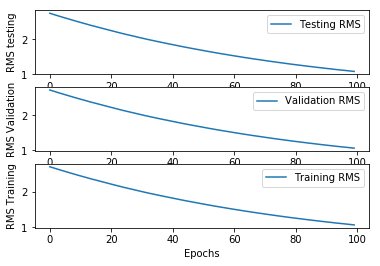

In [368]:
i = [j for j in range(100)]
plt.figure(1)               
ax = plt.subplot(311)
ax.plot(i, L_S_G_Erms_Test[:100],label ='Testing RMS')
plt.ylabel('RMS testing')
plt.xlabel('Epochs')
ax.legend()
ax = plt.subplot(312)             
ax.plot(i, L_S_G_Erms_Val[:100],label ='Validation RMS')
plt.ylabel('RMS Validation')
plt.xlabel('Epochs')
ax.legend()
ax = plt.subplot(313)             
ax.plot(i, L_S_G_Erms_TR[:100],label ='Training RMS')
plt.ylabel('RMS Training')
plt.xlabel('Epochs')
ax.legend()

plt.show()

# Logistic Regression

In [390]:
def LogisticRegression(Target,Features,batchsize,epochs,lr=0.01):
    # Dividing dataset into training,testing and validation
    TrainingTarget,TrainingData = GenerateTargetAndData(Target,Features,TrainingPercent,0)
    print('Training target size:',TrainingTarget.shape)
    print('Training feature size:',TrainingData.shape)
    ValDataAct,ValData = GenerateTargetAndData(Target,Features,ValidationPercent,(len(TrainingTarget)))
    print('Validation target size:',ValDataAct.shape)
    print('Validation feature size:',ValData.shape)
    TestDataAct,TestData = GenerateTargetAndData(Target,Features,TestPercent,(len(TrainingTarget)+len(ValDataAct)))
    print('Testing target size:',TestDataAct.shape)
    print('Testing feature size:',TestData.shape)
    TrainingDataT = np.transpose(TrainingData)
    #initializing weights
    W_Now = np.ones(len(Features))
    W_Now = np.dot(0.1,W_Now)
    La  = 2
   
   
    L_LogLoss_Val   = []
    L_LogLoss_TR    = []
    L_LogLoss_Test  = []
    L_Acc_Val   = []
    L_Acc_TR    = []
    L_Acc_Test  = []
    W_Mat        = []
    for i in tqdm(range(epochs)):
        for i in range(int(len(TrainingTarget)/batchsize)):
            # adapting weights according to the learning rate
            #print ('---------Iteration: ' + str(i) + '--------------')
            lower,upper   = getBounds(i,batchsize,len(TrainingTarget))
            Predicted_T   = np.dot(W_Now,np.transpose(TrainingDataT[lower:upper]))
            Sig_T         = sigmoid_v(Predicted_T)
            Delta         = np.subtract(Sig_T,TrainingTarget[lower:upper])
            Delta_E_D     = np.dot(np.transpose(TrainingDataT[lower:upper]),Delta)
            Delta_W       = -np.dot(lr,Delta_E_D)
            Delta_E_W     = np.dot(1/len(Delta_W),Delta_W)
            W_T_Next      = W_Now + Delta_E_W
            W_Now         = W_T_Next

            # calculating error and accuracy during the learning process
            #-----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = GetValTestSigmoid(TrainingDataT,W_T_Next) 
            LogLoss_TR       = GetCrossEntropy(TR_TEST_OUT,TrainingTarget)
            L_LogLoss_TR.append(float(LogLoss_TR.split(',')[1]))
            L_Acc_TR.append(float(LogLoss_TR.split(',')[0]))

            #-----------------ValidationData Accuracy---------------------#
            VAL_TEST_OUT  = GetValTestSigmoid(np.transpose(ValData),W_T_Next) 
            LogLoss_Val      = GetCrossEntropy(VAL_TEST_OUT,ValDataAct)
            L_LogLoss_Val.append(float(LogLoss_Val.split(',')[1]))
            L_Acc_Val.append(float(LogLoss_Val.split(',')[0]))

            #-----------------TestingData Accuracy---------------------#
            TEST_OUT      = GetValTestSigmoid(np.transpose(TestData),W_T_Next) 
            LogLoss_Test     = GetCrossEntropy(TEST_OUT,TestDataAct)
            L_LogLoss_Test.append(float(LogLoss_Test.split(',')[1]))
            L_Acc_Test.append(float(LogLoss_Test.split(',')[0]))


    return W_Now,L_LogLoss_Val,L_LogLoss_TR,L_LogLoss_Test,L_Acc_Val,L_Acc_TR,L_Acc_Test

In [146]:
#Normalizing values to avoid domain error while taking log
XconcatHODnorm = normalize(XconcatHOD, norm='l2')
XsubtractHODnorm = normalize(XsubtractHOD, norm='l2')

In [168]:
XconcatGSCnorm = normalize(XconcatGSC, norm='l2')
XsubtractGSCnorm = normalize(XsubtractGSC, norm='l2')

In [282]:
batchsize = 5
epochs = 5

W,L_LogLoss_Val,L_LogLoss_TR,L_LogLoss_Test,L_Acc_Val,L_Acc_TR,L_Acc_Test = LogisticRegression(TconcatHOD,XconcatHOD,batchsize,epochs)


Training target size: (1266,)
Training feature size: (18, 1266)
Validation target size: (158,)
Validation feature size: (18, 158)
Testing target size: (157,)
Testing feature size: (18, 157)


In [283]:
print ('Logistic Regression | Concatenation | Human Observed Dataset')
print ("LogLoss Training   = " + str(np.around(min(L_LogLoss_TR),5)))
print ("LogLoss Validation = " + str(np.around(min(L_LogLoss_Val),5)))
print ("LogLoss Testing    = " + str(np.around(min(L_LogLoss_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_Acc_Test),5)))

Logistic Regression | Concatenation | Human Observed Dataset
LogLoss Training   = 0.68474
LogLoss Validation = 0.68434
LogLoss Testing    = 0.69288
Accuracy Training   = 57.81991
Accuracy Validation = 59.49367
Accuracy Testing    = 57.32484


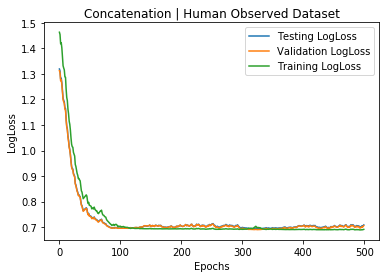

In [288]:
i = [j for j in range(500)]
plt.figure(1)               
ax = plt.subplot(111)
ax.plot(i, L_LogLoss_Test[:500],label ='Testing LogLoss')
plt.ylabel('LogLoss')
plt.xlabel('Epochs')       
ax.plot(i, L_LogLoss_Val[:500],label ='Validation LogLoss')
ax.plot(i, L_LogLoss_TR[:500],label ='Training LogLoss')
ax.legend()
plt.title('Concatenation | Human Observed Dataset')
plt.show()

In [369]:
batchsize = 5
epochs = 10
W,L_S_LogLoss_Val,L_S_LogLoss_TR,L_S_LogLoss_Test,L_S_Acc_Val,L_S_Acc_TR,L_S_Acc_Test = LogisticRegression(TsubtractHOD,XsubtractHODnorm,batchsize,epochs,0.2)



Training target size: (1266,)
Training feature size: (9, 1266)
Validation target size: (158,)
Validation feature size: (9, 158)
Testing target size: (157,)
Testing feature size: (9, 157)


In [370]:
print ('Logistic Regression | Subtraction | Human Observed Dataset')
print ("LogLoss Training   = " + str(np.around(min(L_S_LogLoss_TR),5)))
print ("LogLoss Validation = " + str(np.around(min(L_S_LogLoss_Val),5)))
print ("LogLoss Testing    = " + str(np.around(min(L_S_LogLoss_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_S_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_S_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_S_Acc_Test),5)))

Logistic Regression | Subtraction | Human Observed Dataset
LogLoss Training   = 0.69309
LogLoss Validation = 0.69265
LogLoss Testing    = 0.69331
Accuracy Training   = 50.0
Accuracy Validation = 53.79747
Accuracy Testing    = 47.7707


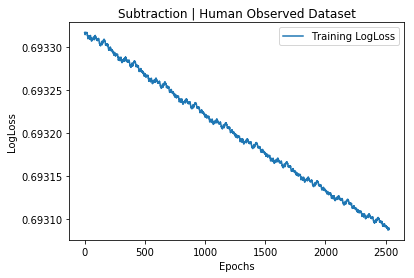

In [375]:
i = [j for j in range(2530)]
plt.figure(1)               
ax = plt.subplot(111)
#ax.plot(i, L_S_LogLoss_Val[:2530],label ='Testing LogLoss')
plt.ylabel('LogLoss')
plt.xlabel('Epochs')       
#ax.plot(i, L_S_LogLoss_Val[:2530],label ='Validation LogLoss')
ax.plot(i, L_S_LogLoss_TR[:2530],label ='Training LogLoss')
ax.legend()
plt.title('Subtraction | Human Observed Dataset')
plt.show()

In [357]:
batchsize = 5000
epochs = 100
W,L_C_G_LogLoss_TR,L_C_G_LogLoss_Val,L_C_G_LogLoss_Test,L_C_G_Acc_Val,L_C_G_Acc_TR,L_C_G_Acc_Test = LogisticRegression(TconcatGSC,XconcatGSCnorm,batchsize,epochs,0.2)


Training target size: (40000,)
Training feature size: (1024, 40000)
Validation target size: (4999,)
Validation feature size: (1024, 4999)
Testing target size: (4999,)
Testing feature size: (1024, 4999)


In [358]:
print ('Logistic Regression | Concatenation | GSC Dataset')
print ("LogLoss Training   = " + str(np.around(min(L_C_G_LogLoss_TR),5)))
print ("LogLoss Validation = " + str(np.around(min(L_C_G_LogLoss_Val),5)))
print ("LogLoss Testing    = " + str(np.around(min(L_C_G_LogLoss_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_C_G_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_C_G_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_C_G_Acc_Test),5)))

Logistic Regression | Concatenation | GSC Dataset
LogLoss Training   = 0.69249
LogLoss Validation = 0.69287
LogLoss Testing    = 0.69216
Accuracy Training   = 49.8825
Accuracy Validation = 50.05001
Accuracy Testing    = 50.89018


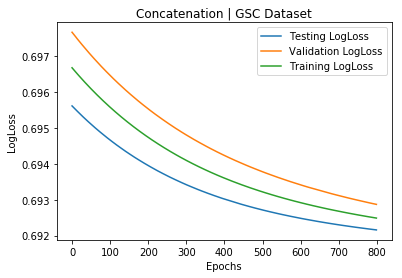

In [359]:
i = [j for j in range(800)]
plt.figure(1)               
ax = plt.subplot(111)
ax.plot(i, L_C_G_LogLoss_Test,label ='Testing LogLoss')
plt.ylabel('LogLoss')
plt.xlabel('Epochs')       
ax.plot(i, L_C_G_LogLoss_Val,label ='Validation LogLoss')
ax.plot(i, L_C_G_LogLoss_TR,label ='Training LogLoss')
ax.legend()
plt.title('Concatenation | GSC Dataset')
plt.show()


In [354]:
batchsize = 5000
epochs = 100
W,L_S_G_LogLoss_Val,L_S_G_LogLoss_TR,L_S_G_LogLoss_Test,L_S_G_Acc_Val,L_S_G_Acc_TR,L_S_G_Acc_Test = LogisticRegression(TsubtractGSC,XsubtractGSCnorm,batchsize,epochs,0.2)

Training target size: (40000,)
Training feature size: (512, 40000)
Validation target size: (4999,)
Validation feature size: (512, 4999)
Testing target size: (4999,)
Testing feature size: (512, 4999)


In [355]:
print ('Logistic Regression | Subtraction | GSC Dataset')
print ("LogLoss Training   = " + str(np.around(min(L_S_G_LogLoss_TR),5)))
print ("LogLoss Validation = " + str(np.around(min(L_S_G_LogLoss_Val),5)))
print ("LogLoss Testing    = " + str(np.around(min(L_S_G_LogLoss_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_S_G_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_S_G_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_S_G_Acc_Test),5)))

Logistic Regression | Subtraction | GSC Dataset
LogLoss Training   = 0.68539
LogLoss Validation = 0.68513
LogLoss Testing    = 0.68461
Accuracy Training   = 61.5375
Accuracy Validation = 61.67233
Accuracy Testing    = 61.75235


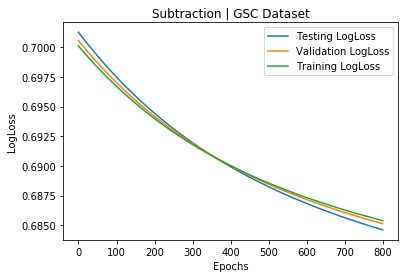

In [356]:
i = [j for j in range(800)]
plt.figure(1)               
ax = plt.subplot(111)
ax.plot(i, L_S_G_LogLoss_Test,label ='Testing LogLoss')
plt.ylabel('LogLoss')
plt.xlabel('Epochs')       
ax.plot(i, L_S_G_LogLoss_Val,label ='Validation LogLoss')
ax.plot(i, L_S_G_LogLoss_TR,label ='Training LogLoss')
ax.legend()
plt.title('Subtraction | GSC Dataset')
plt.show()


# Neural Network

In [420]:
def NeuralNetwork(Features,Target,drop_out=0.2,first_dense_layer_nodes=1024,second_dense_layer_nodes=2,learning_rate=0.001):
    input_size = len(Features[0])

    model = Sequential()
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))


    model.add(Dropout(drop_out))

    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('softmax'))

    model.summary()

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    validation_data_split = 0.2
    num_epochs = 10000
    model_batch_size = 128
    tb_batch_size = 32
    early_patience = 100
   
    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
   
   
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
    processedLabel = np_utils.to_categorical(Target) 
    history = model.fit(Features
                        , processedLabel
                        , validation_split=validation_data_split
                        , epochs=num_epochs
                        , batch_size=model_batch_size
                        , callbacks = [tensorboard_cb,earlystopping_cb]
                       )
    predictedLabel =  []
    right=0
    wrong=0

    for i,j in zip(Features,processedLabel):
        y = model.predict(np.array(i).reshape(-1,input_size))
        predictedLabel.append(y.argmax())

        if j.argmax() == y.argmax():
            right = right + 1
        else:
            wrong = wrong + 1

    return history,str(right/(right+wrong)*100)

In [421]:
TconcatHODre= np.reshape(TconcatHOD,(1582,1))
history,accuracy = NeuralNetwork(np.transpose(XconcatHOD),TconcatHODre)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 1024)              19456     
_________________________________________________________________
activation_87 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 2)                 2050      
_________________________________________________________________
activation_88 (Activation)   (None, 2)                 0         
Total params: 21,506
Trainable params: 21,506
Non-trainable params: 0
_________________________________________________________________
Train on 1265 samples, validate on 317 samples
Epoch 1/10000
1265/1265 [==============================] - 0s 296us/step - loss: 0.7963 - a

1265/1265 [==============================] - 0s 20us/step - loss: 0.5263 - acc: 0.7502 - val_loss: 0.7610 - val_acc: 0.5615
Epoch 53/10000
1265/1265 [==============================] - 0s 18us/step - loss: 0.5466 - acc: 0.7130 - val_loss: 0.7762 - val_acc: 0.5268
Epoch 54/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.5218 - acc: 0.7534 - val_loss: 0.7810 - val_acc: 0.5110
Epoch 55/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.5140 - acc: 0.7581 - val_loss: 0.8081 - val_acc: 0.5079
Epoch 56/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.5229 - acc: 0.7470 - val_loss: 0.7721 - val_acc: 0.5300
Epoch 57/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.5102 - acc: 0.7462 - val_loss: 0.7721 - val_acc: 0.5300
Epoch 58/10000
1265/1265 [==============================] - 0s 22us/step - loss: 0.5046 - acc: 0.7692 - val_loss: 0.7963 - val_acc: 0.5016
Epoch 59/10000
1265/1265 [================

Neural Network | Concatenation | Human Observed Dataset
Accuracy: 82.7433628318584


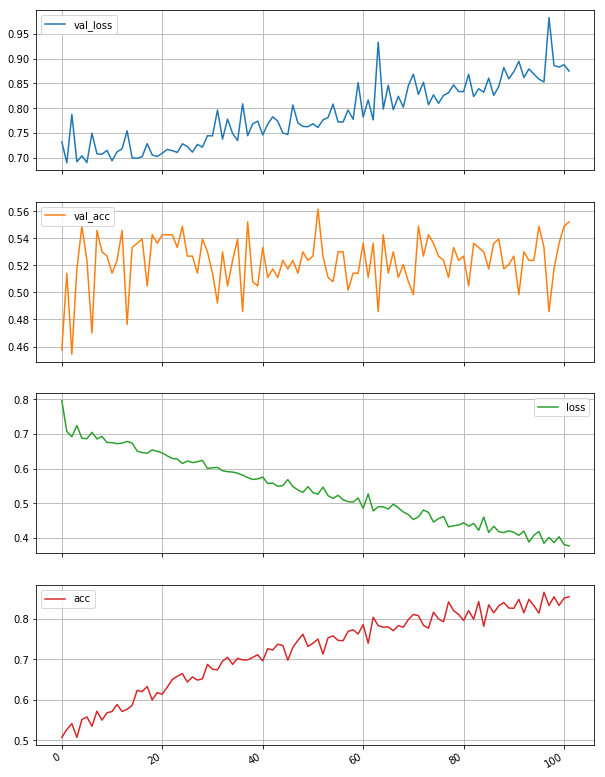

In [422]:
%matplotlib inline
df = pandas.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))
print ('Neural Network | Concatenation | Human Observed Dataset')
print('Accuracy:',accuracy)

In [423]:
TsubtractHODre= np.reshape(TsubtractHOD,(1582,1))
history,accuracy = NeuralNetwork(np.transpose(XsubtractHOD),TsubtractHODre)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 1024)              10240     
_________________________________________________________________
activation_89 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 2050      
_________________________________________________________________
activation_90 (Activation)   (None, 2)                 0         
Total params: 12,290
Trainable params: 12,290
Non-trainable params: 0
_________________________________________________________________
Train on 1265 samples, validate on 317 samples
Epoch 1/10000
1265/1265 [==============================] - 0s 266us/step - loss: 0.7189 - a

1265/1265 [==============================] - 0s 19us/step - loss: 0.6121 - acc: 0.6585 - val_loss: 0.6911 - val_acc: 0.5710
Epoch 53/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.6055 - acc: 0.6751 - val_loss: 0.6973 - val_acc: 0.5394
Epoch 54/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.6070 - acc: 0.6632 - val_loss: 0.6991 - val_acc: 0.5457
Epoch 55/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.6047 - acc: 0.6798 - val_loss: 0.6960 - val_acc: 0.5363
Epoch 56/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.6024 - acc: 0.6632 - val_loss: 0.6981 - val_acc: 0.5394
Epoch 57/10000
1265/1265 [==============================] - 0s 20us/step - loss: 0.6025 - acc: 0.6783 - val_loss: 0.6976 - val_acc: 0.5268
Epoch 58/10000
1265/1265 [==============================] - 0s 21us/step - loss: 0.6006 - acc: 0.6696 - val_loss: 0.7034 - val_acc: 0.5363
Epoch 59/10000
1265/1265 [================

Epoch 111/10000
1265/1265 [==============================] - 0s 20us/step - loss: 0.5245 - acc: 0.7462 - val_loss: 0.7408 - val_acc: 0.5142
Epoch 112/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.5354 - acc: 0.7399 - val_loss: 0.7480 - val_acc: 0.5174
Epoch 113/10000
1265/1265 [==============================] - 0s 19us/step - loss: 0.5257 - acc: 0.7399 - val_loss: 0.7529 - val_acc: 0.5300
Epoch 114/10000
1265/1265 [==============================] - 0s 21us/step - loss: 0.5190 - acc: 0.7636 - val_loss: 0.7935 - val_acc: 0.5110
Epoch 115/10000
1265/1265 [==============================] - 0s 21us/step - loss: 0.5279 - acc: 0.7462 - val_loss: 0.7476 - val_acc: 0.5300
Epoch 116/10000
1265/1265 [==============================] - 0s 21us/step - loss: 0.5275 - acc: 0.7439 - val_loss: 0.7520 - val_acc: 0.5237
Epoch 117/10000
1265/1265 [==============================] - 0s 20us/step - loss: 0.5146 - acc: 0.7542 - val_loss: 0.7437 - val_acc: 0.5363
Epoch 118/10000
1265

Neural Network | Subtraction | Human Observed Dataset
Accuracy: 73.51453855878634


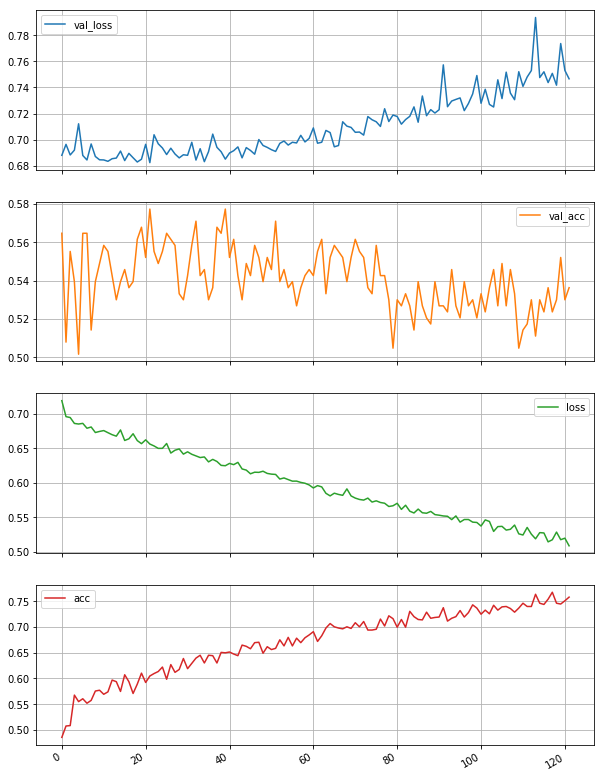

In [424]:
%matplotlib inline
df = pandas.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))
print ('Neural Network | Subtraction | Human Observed Dataset')
print('Accuracy:',accuracy)

In [426]:
TconcatGSCre= np.reshape(TsubtractGSC,(50000,1))
history,accuracy = NeuralNetwork(np.transpose(XconcatGSC),TconcatGSCre)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
activation_91 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 2)                 2050      
_________________________________________________________________
activation_92 (Activation)   (None, 2)                 0         
Total params: 1,051,650
Trainable params: 1,051,650
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 10000 samples
Epoch 1/10000
40000/40000 [==============================] - 5s 119us/step - loss:

40000/40000 [==============================] - 4s 94us/step - loss: 0.0345 - acc: 0.9882 - val_loss: 3.4061 - val_acc: 0.4987
Epoch 52/10000
40000/40000 [==============================] - 4s 94us/step - loss: 0.0306 - acc: 0.9892 - val_loss: 3.4814 - val_acc: 0.5000
Epoch 53/10000
40000/40000 [==============================] - 4s 93us/step - loss: 0.0373 - acc: 0.9878 - val_loss: 3.4488 - val_acc: 0.5023
Epoch 54/10000
40000/40000 [==============================] - 4s 91us/step - loss: 0.0307 - acc: 0.9901 - val_loss: 3.5435 - val_acc: 0.5093
Epoch 55/10000
40000/40000 [==============================] - 3s 87us/step - loss: 0.0348 - acc: 0.9890 - val_loss: 3.5366 - val_acc: 0.4990
Epoch 56/10000
40000/40000 [==============================] - 4s 92us/step - loss: 0.0317 - acc: 0.9894 - val_loss: 3.6203 - val_acc: 0.5003
Epoch 57/10000
40000/40000 [==============================] - 4s 96us/step - loss: 0.0305 - acc: 0.9900 - val_loss: 3.6617 - val_acc: 0.4987
Epoch 58/10000
40000/40000 [

Neural Network | Concatenation | GSC Dataset
Accuracy: 90.044


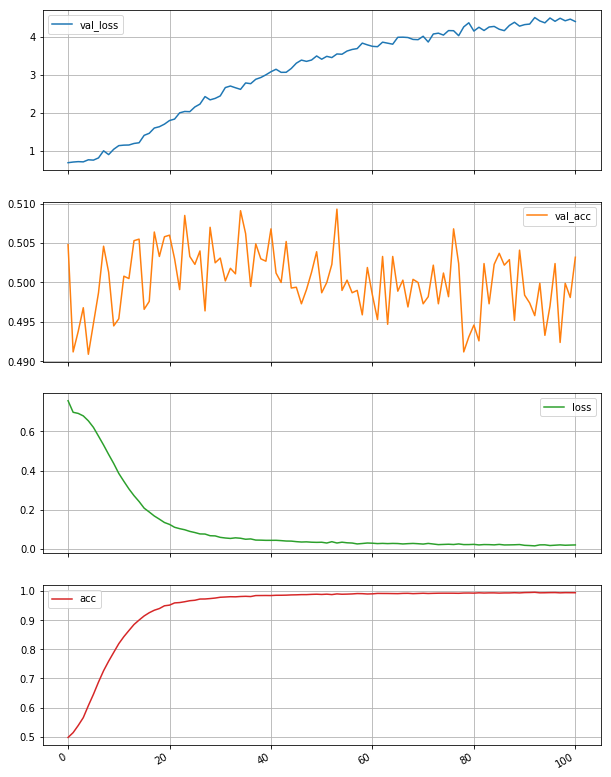

In [427]:
%matplotlib inline
df = pandas.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))
print ('Neural Network | Concatenation | GSC Dataset')
print('Accuracy:',accuracy)

In [428]:
TsubtractGSCre= np.reshape(TsubtractGSC,(50000,1))
history,accuracy = NeuralNetwork(np.transpose(XsubtractGSC),TsubtractGSCre)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 1024)              525312    
_________________________________________________________________
activation_93 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 2050      
_________________________________________________________________
activation_94 (Activation)   (None, 2)                 0         
Total params: 527,362
Trainable params: 527,362
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 10000 samples
Epoch 1/10000
40000/40000 [==============================] - 2s 59us/step - loss: 0.53

40000/40000 [==============================] - 2s 50us/step - loss: 1.1773e-04 - acc: 1.0000 - val_loss: 0.9110 - val_acc: 0.8419
Epoch 52/10000
40000/40000 [==============================] - 2s 50us/step - loss: 1.2568e-04 - acc: 1.0000 - val_loss: 0.9179 - val_acc: 0.8424
Epoch 53/10000
40000/40000 [==============================] - 2s 51us/step - loss: 4.7827e-05 - acc: 1.0000 - val_loss: 1.0252 - val_acc: 0.8431
Epoch 54/10000
40000/40000 [==============================] - 2s 50us/step - loss: 1.2174e-04 - acc: 1.0000 - val_loss: 1.0534 - val_acc: 0.8436
Epoch 55/10000
40000/40000 [==============================] - 2s 52us/step - loss: 1.0671e-04 - acc: 1.0000 - val_loss: 0.9603 - val_acc: 0.8425
Epoch 56/10000
40000/40000 [==============================] - 2s 52us/step - loss: 6.4314e-05 - acc: 1.0000 - val_loss: 1.0421 - val_acc: 0.8431
Epoch 57/10000
40000/40000 [==============================] - 2s 56us/step - loss: 4.6435e-05 - acc: 1.0000 - val_loss: 1.1203 - val_acc: 0.8452


Neural Network | Subtraction | GSC Dataset
Accuracy: 96.904


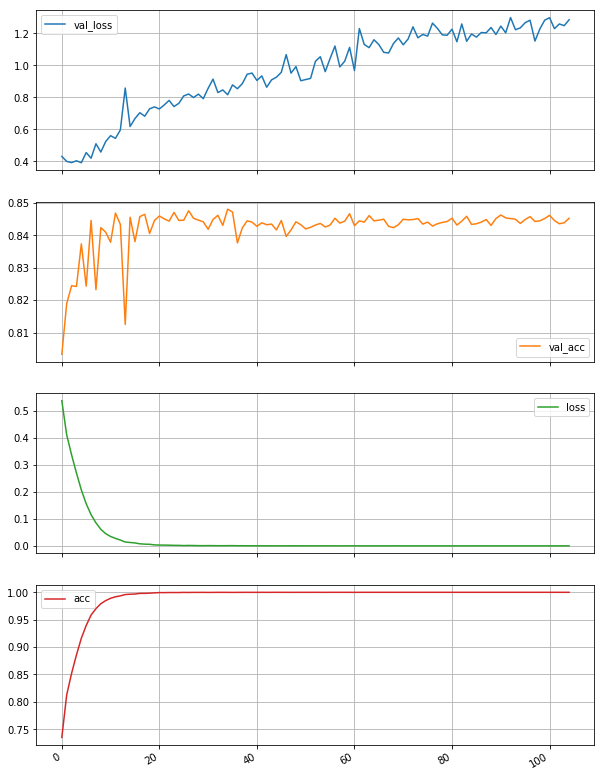

In [429]:
%matplotlib inline
df = pandas.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))
print ('Neural Network | Subtraction | GSC Dataset')
print('Accuracy:',accuracy)